In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario, read_ontario_stations
from source.read_hongkong import read_hongkong
from source.app_dataset import OntarioDataset, BrasilDataset, HongKongDataset
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures
from cuml.manifold import UMAP
from source.featlearn.byol import BYOL
# , BarlowTwins
# from ccpca import CCPCA

VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 150
BATCH_SIZE = 128
ENC_SIZE = 8 # 8
# POLLUTANTS = ['PM25', 'CO', 'NO'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
POLLUTANTS = ['CO', 'O3', 'FSP', 'NOX'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Months case

In [2]:
dataset = HongKongDataset(fill_missing=True, max_missing=0.1, granularity='daily')
print(dataset.pollutants)

['NO2', 'NOX', 'O3', 'SO2', 'RSP', 'FSP', 'CO']


In [3]:
import aqi

available_polls = ['O3', 'PM25', 'PM10', 'FSP', 'NO2', 'SO2', 'CO']


def filter_iaqi(pollutants, values): # values shape NxD
    out_index = []
    for i in range(len(pollutants)):
        if pollutants[i] in available_polls:
            out_index.append(i)
    return np.array(pollutants)[out_index], values[:, :, out_index]

def daily_iaqi(pollutant, data):
    if pollutant == 'O3':
        d_mean = data.mean()
        return aqi.to_iaqi('o3_8h', str(d_mean), algo=aqi.ALGO_MEP)
    elif pollutant == 'PM25' or pollutant == 'FSP':
        d_mean = data.mean()
        return aqi.to_iaqi(aqi.POLLUTANT_PM25, str(d_mean), algo=aqi.ALGO_EPA)
    elif pollutant == 'PM10' or pollutant == 'RSP':
        d_mean = data.mean()
        return aqi.to_iaqi(aqi.POLLUTANT_PM10, str(d_mean), algo=aqi.ALGO_EPA)
    elif pollutant == 'NO2':
        d_mean = data.mean()
        return aqi.to_iaqi('no2_24h', str(d_mean), algo=aqi.ALGO_MEP)
    elif pollutant == 'SO2':
        d_mean = data.mean()
        return aqi.to_iaqi('so2_24h', str(d_mean), algo=aqi.ALGO_MEP)
    elif pollutant == 'CO':
        d_mean = data.mean()
        return aqi.to_iaqi('co_24h', str(d_mean), algo=aqi.ALGO_MEP)



def get_aqi(pollutants, values): # values shape NxD
    iaqis = []
    for i in range(len(pollutants)):
        pollutant = pollutants[i]
        data = values[:, i]
        if pollutant == 'O3':
            d_mean = data.mean()
            iaqis.append(('o3_8h', str(d_mean)))
        elif pollutant == 'PM25' or pollutant == 'FSP':
            d_mean = data.mean()
            iaqis.append(('pm25', str(d_mean)))
        elif pollutant == 'PM10' or pollutant == 'RSP':
            d_mean = data.mean()
            # return aqi.to_iaqi(aqi.POLLUTANT_PM10, str(d_mean), algo=aqi.ALGO_EPA)
            iaqis.append(('pm10', str(d_mean)))
        elif pollutant == 'NO2':
            d_mean = data.mean()
            iaqis.append(('no2_24h', str(d_mean)))
        elif pollutant == 'SO2':
            d_mean = data.mean()
            iaqis.append(('so2_24h', str(d_mean)))
        elif pollutant == 'CO':
            d_mean = data.mean()
            iaqis.append(('co_24h', str(d_mean)))
    return aqi.to_aqi(iaqis, algo=aqi.ALGO_MEP)
       

In [4]:


# windows_map = read_ontario(granularity='months', cache=True)
# windows_map = read_hongkong(granularity='years', cache=True)
# windows_map = read_hongkong(granularity='months', cache=True)
windows_map = read_hongkong(granularity='daily', cache=True)

# data_info = read_ontario_stations()
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [5]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
# dataset.stations
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans, dataset.stations)

In [7]:

# print(pollutans)

filtered_pollutans, filtered_windows = filter_iaqi(pollutans, windows)

print(filtered_windows.shape)
print(filtered_windows.max())
print(filtered_windows.min())
print(filtered_pollutans)
# print(filtered_windows)
# print(filtered_windows.shape)
# print(windows.shape)
aqis = [int(get_aqi(filtered_pollutans, filtered_windows[i])) for i in range(len(filtered_windows))]
print(aqis)

print('iaqis')
iaqis = [int(daily_iaqi(filtered_pollutans[0], filtered_windows[i,:,0])) for i in range(len(filtered_windows))]
print(iaqis)
iaqis = [int(daily_iaqi(filtered_pollutans[1], filtered_windows[i,:,1])) for i in range(len(filtered_windows))]
print(iaqis)
iaqis = [int(daily_iaqi(filtered_pollutans[2], filtered_windows[i,:,2])) for i in range(len(filtered_windows))]
print(iaqis)


(35983, 24, 3)
434.0
-34.49238018499392
['CO' 'O3' 'FSP']
[150, 139, 145, 150, 134, 139, 145, 139, 156, 145, 162, 139, 145, 189, 167, 151, 139, 156, 145, 134, 150, 139, 139, 139, 151, 139, 134, 128, 139, 123, 134, 128, 112, 128, 134, 128, 128, 106, 101, 117, 134, 117, 123, 117, 128, 128, 117, 101, 106, 100, 100, 101, 100, 101, 100, 106, 112, 128, 112, 61, 62, 112, 123, 101, 101, 100, 101, 101, 101, 101, 101, 123, 117, 117, 106, 112, 106, 101, 112, 128, 123, 101, 117, 112, 112, 128, 128, 112, 106, 123, 51, 106, 51, 51, 100, 112, 112, 117, 117, 112, 106, 112, 112, 112, 106, 106, 100, 101, 112, 106, 101, 106, 139, 128, 145, 150, 139, 139, 139, 123, 134, 117, 106, 101, 101, 100, 100, 100, 100, 112, 134, 123, 134, 123, 123, 123, 101, 50, 100, 117, 112, 101, 106, 106, 101, 106, 117, 101, 112, 134, 128, 112, 101, 112, 112, 101, 101, 106, 128, 112, 100, 106, 101, 100, 100, 101, 101, 139, 128, 128, 117, 117, 112, 112, 139, 134, 117, 123, 112, 117, 117, 112, 117, 150, 139, 134, 134, 145, 145, 14

In [27]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}
# coords = np.array([
#     [
#         float(data_info[str(stations[station_ids[i]])]['latitude']), 
#         float(data_info[str(stations[station_ids[i]])]['longitude'])
#     ]
#     for i in range(len(windows))
# ])

In [6]:
# dates
import datetime

epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

# unix_time_millis(dates[0])

timeInMs = np.array([unix_time_millis(d) for d in dates])
timeInMs = np.expand_dims(timeInMs, axis=1)


In [22]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 43913, T: 24, D: 2 
(43913, 2, 24)


In [23]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC, VAE_FL
from sklearn.model_selection import train_test_split

# cae = AutoencoderFL(mts.D, mts.T, feature_size=10)
# cae = DCEC(mts.D, mts.T, feature_size=10, n_clusters=5)
# cae = VAE_FL(mts.D, mts.T, feature_size=10)

X_train, X_val = train_test_split(mts.X.transpose([0, 2, 1]))


# model = BarlowTwins(mts.D, mts.T, feature_size=10, aug_type='noise', encoding_size=6, use_frequency=False)
model = BYOL(mts.D, mts.T, feature_size=7, aug_type='noise', encoding_size=6, use_frequency=False)

# model.fit(mts.X, epochs=1400, batch_size=320)
# model.fit(X_train, epochs=200, batch_size=320, X_val=X_val)
model.fit(X_train, epochs=10, batch_size=320, X_val=X_val)
# cae.fit(mts.X, epochs=1000, batch_size=320, gamma=0)

Using CNN backbone

Epoch[1] Train loss    avg: -0.9423309027859308
Epoch[1] Val loss    avg: -0.9911427191325597
Epoch[5] Train loss    avg: -0.9993325871171304
Epoch[5] Val loss    avg: -0.9976640599114555
Epoch[10] Train loss    avg: -0.9994955253832548
Epoch[10] Val loss    avg: -0.9984192388398306


(<source.utils.ValueLogger at 0x7f0a1eb4e9d0>,
 <source.utils.ValueLogger at 0x7f0a1eb4ea30>)

In [25]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC




# cae.fit(mts.X, epochs=1000, batch_size=320, gamma=100)
# rec, mts.features, clusters = cae.encode(mts.X)
# rec, mts.features = cae.encode(mts.X)


mts.features = model.encode(mts.X.transpose([0, 2, 1]))


In [23]:
# mts.features.min()

0.0

In [10]:
# def jitter(x, sigma=0.01):
#     # https://arxiv.org/pdf/1706.00527.pdf
#     return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

# time = X_train[0]
# time = jitter(time)
# plt.plot(time[0])

In [11]:
from sklearn.metrics import pairwise_distances

delta = 0.
beta = 0.

space_DM = pairwise_distances(coords)
space_DM = space_DM / np.max(space_DM)

feature_DM = pairwise_distances(mts.features, metric='euclidean')
feature_DM = feature_DM / np.max(feature_DM)


time_DM = pairwise_distances(timeInMs)
time_DM = time_DM / np.max(time_DM)

# distM = feature_DM * (1 - delta) + space_DM * delta
distM = feature_DM * (1 - (delta + beta)) + space_DM * delta + time_DM * beta
# mts.features = np.concatenate([mts.features, coords], axis=1)

In [12]:
# # # clusters
# preds = np.argmax(clusters, axis=1)
# print(np.unique(preds, return_counts=True))

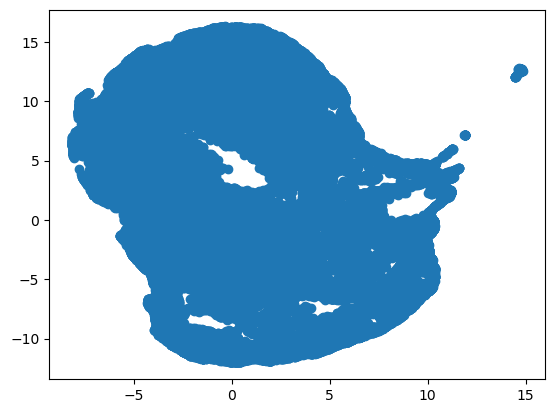

In [26]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_components=2, metric='euclidean')
# reducer = umap.UMAP(n_components=2, metric='precomputed')
# reducer = TSNE(n_components=2, metric='precomputed')

# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

# coords = reducer.fit_transform(mts.features, y = month_ids)
coords = reducer.fit_transform(mts.features)
# coords = reducer.fit_transform(distM)

# plt.scatter(coords[:, 0], coords[:, 1], c=preds)
plt.scatter(coords[:, 0], coords[:, 1])

In [14]:
import matplotlib.pyplot as plt

def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x)
    if x2 is not None:
        plt.plot(steps, x2)
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    # plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

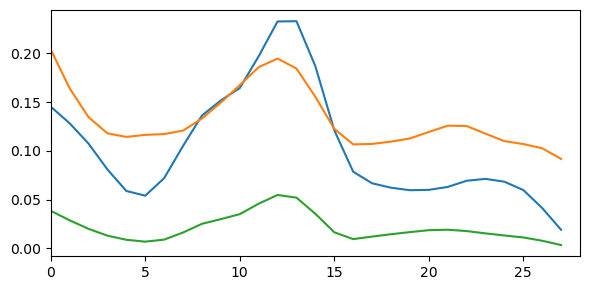

In [15]:
pos = 90
plot1d(mts.X[pos])

In [16]:
plot1d(rec[pos])

NameError: name 'rec' is not defined